In [1]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import io, feature, filters, morphology, transform

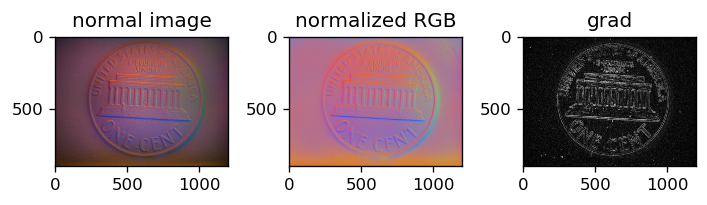

In [2]:
plt.figure(dpi=120)

img_full = np.array(io.imread('image01.png'))
img_crop = img_full[200:1100,400:1600:]
img_crop = img_crop/255.0
plt.subplot(1,3,1)
plt.title('normal image')
plt.imshow(img_crop)
plt.subplot(1,3,2)
plt.imshow(img_crop/np.linalg.norm(img_crop,axis=2,keepdims=True))
plt.title('normalized RGB')
plt.subplot(1,3,3)
grad_raw = filters.sobel(img_crop[:,:,0]) + filters.sobel(img_crop[:,:,1]) + filters.sobel(img_crop[:,:,2])
plt.imshow(grad_raw,cmap='Greys_r')
plt.title('grad')
plt.tight_layout()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


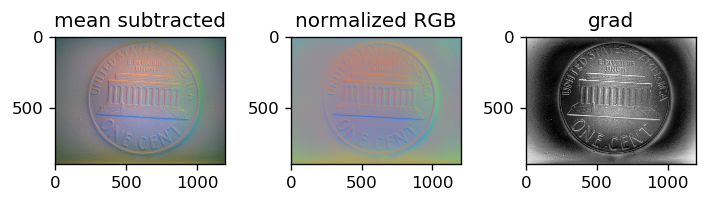

In [3]:
plt.figure(dpi=120)
mean_sub = img_crop-img_crop.mean((0,1))
plt.subplot(1,3,1)
plt.title('mean subtracted')
plt.imshow(mean_sub+0.5)
plt.subplot(1,3,2)
mean_clip = np.clip(mean_sub+0.5,0,1.0)
plt.imshow(mean_clip/np.linalg.norm(mean_clip,axis=2,keepdims=True))
plt.title('normalized RGB')
plt.subplot(1,3,3)
mean_grad = np.sqrt((mean_sub**2)).mean(2)
plt.imshow(mean_grad,cmap='Greys_r')
plt.title('grad')
plt.tight_layout()


/Users/lkeselma/anaconda/lib/python3.6/site-packages/skimage/filters/_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


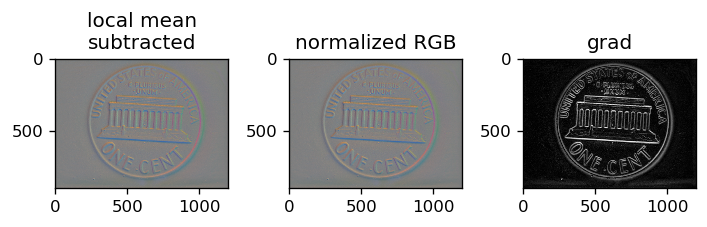

In [4]:
plt.figure(dpi=120)
background_color = filters.gaussian(mean_sub,sigma=35)
local_mean_sub = mean_sub-background_color
plt.subplot(1,3,1)
plt.title('local mean\nsubtracted')
plt.imshow(local_mean_sub+0.5)
plt.subplot(1,3,2)
local_mean_clip = np.clip(local_mean_sub+0.5,0,1.0)
local_mean_clip_norm = local_mean_clip/np.linalg.norm(local_mean_clip,axis=2,keepdims=True)
plt.imshow(local_mean_clip)
plt.title('normalized RGB')
plt.subplot(1,3,3)
local_mean_grad = np.sqrt((local_mean_sub**2)).mean(2)
plt.imshow(local_mean_grad,cmap='Greys_r')
plt.title('grad')
plt.tight_layout()

# shape from shading
following [Zheng, Qinfen, and Rama Chellappa. "Estimation of Illuminant Direction, Albedo, and Shape from Shading." IEEE Transactions on Pattern Analysis and Machine Intelligence 13.7 (1991): 680-702.](https://pdfs.semanticscholar.org/e80f/3b32f1bee2f3ec4972cf222646737520ce7c.pdf) for some of the lighting estimation

## estimate lighting directions

0.5284901004209767 0.0 1.5366958053506856
0.3337322863384688 0.0 2.461050024631331
0.4283844688733507 0.2996266016745127 1.5844545936874859
[0.11764706 0.10588235 0.04313725]
[0.99607843 0.58431373 0.72941176]
[[ 0.          0.          1.        ]
 [-0.          0.          1.        ]
 [-0.0040313   0.29513593  0.95544677]]


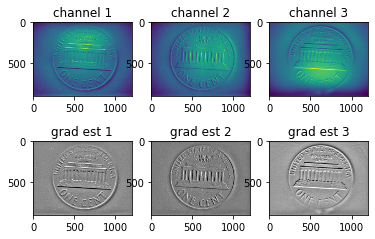

In [5]:
light_dirs = []
albedos = []
for i, img in enumerate(img_crop.T):
    plt.subplot(2,3,i+1)
    img = img.T
    plt.imshow(img)
    #plt.figure()
    plt.title('channel {}'.format(i+1))
    plt.subplot(2,3,4+i)
    plt.imshow(0.5+local_mean_sub[:,:,i],cmap='Greys_r')
    #plt.figure()
    plt.title('grad est {}'.format(i+1))
    
    u1 = img.mean()
    u2 = (img**2).mean()
    
    gamma = np.sqrt(6*(np.pi**2)*u2 - 48*(u1**2))
    albedo = gamma/np.pi
    # sometimes it blows up.... i don't think it should
    # standard deviations integrate over [0,pi/2] but here the angle is steeper
    # i just clip it, but this leads to a degenerate solution!
    cos_sigma = (4*u1)/gamma
    cos_sigma = min(1,cos_sigma)
    slant = np.arccos(cos_sigma)
    
    Ex = filters.sobel_h(img)
    Ey = filters.sobel_v(img)
    Exy = np.sqrt(Ex**2 + Ey**2) + 1e-2
    nEx = Ex / (Exy )
    nEy = Ey / (Exy )
    tilt = np.arctan(nEx.mean()/nEy.mean())
    if tilt < 0:
        tilt += np.pi
    print(albedo,slant,tilt)
    albedos.append(albedo)
    light_dirs.append([np.cos(tilt)*np.sin(slant),np.sin(tilt)*np.sin(slant),np.cos(slant)])
print(img_crop.min(axis=(0,1)))
print(img_crop.max(axis=(0,1)))
print(np.array(light_dirs))

## direct analytical shape from shading
Simple image formation model is $E(x,y) = \rho i^T n$ with albedo $\rho$, light source direction $i$ and surface normal $n$

so we can just solve the linear system! given marix $L$ the light sources as columns
$\hat{n}(x,y) = L^{-1} E(x,y) $
and then normalize to get a vector

Text(0.5, 0.75, 'dot product estimate')

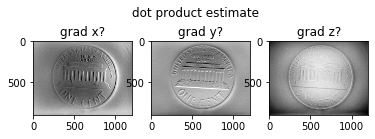

In [6]:
# light should just be a dot product of normal and light direction.
# so we should be able to invert and solve for normals. 

# plug in/optimize/find these
light_dir =[  [0,-.5,1], [.5,0,1], [0,.5,1]  ]
light_dir = np.array(light_dir)
light_dir /= np.linalg.norm(light_dir,axis=1)

#  to use the derived ones above
#light_dir = light_dirs

# solve
n_img = (np.linalg.pinv(light_dir) @ img_crop.reshape((-1,3)).T).T.reshape(img_crop.shape)

# scale based on assumed reflectance
n_img *= 1/np.array(albedos)

for i, img in enumerate(n_img.T):
    plt.subplot(1,3,i+1)
    img = img.T
    plt.imshow(img,cmap='Greys_r')
    #plt.figure()
    plt.title('grad {}?'.format(['x','y','z'][i]))
plt.suptitle('dot product estimate',y=0.75)

In [7]:
light_dir

array([[ 0.        , -0.4472136 ,  0.89442719],
       [ 0.4472136 ,  0.        ,  0.89442719],
       [ 0.        ,  0.4472136 ,  0.89442719]])

In [8]:
n_img = n_img/np.linalg.norm(n_img,axis=2,keepdims=True)

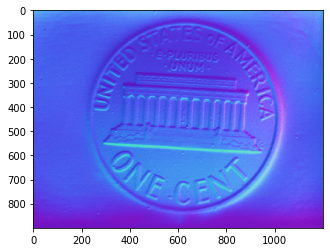

In [9]:
plt.imshow(0.5*(n_img+1),vmin=-1,vmax=1)

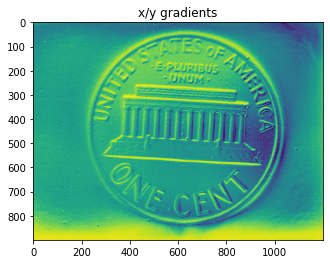

In [10]:
plt.title("x/y gradients")
plt.imshow(np.sqrt(n_img[:,:,1]**2 + n_img[:,:,0]**2))

## iterative shape from shading 
Here we'll only do this for the last channel, following [Ping-Sing, Tsai, and Mubarak Shah. "Shape from shading using linear approximation." Image and Vision computing 12.8 (1994): 487-498.](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.31.9148&rep=rep1&type=pdf)

In [11]:
maxIter = 200

img = img_crop[:,:,2]
# we'll reuse slant and tilt from the last loop iteration

normals = np.zeros((img_crop.shape[0],img_crop.shape[1],2))
depth = np.zeros((img_crop.shape[0],img_crop.shape[1]))
ix = np.cos(tilt) * np.tan(slant)
iy = np.sin(tilt) * np.tan(slant)
iT = np.array([ix,iy])
print(normals.shape)

for i in range(maxIter):
    R = (np.cos(slant) \
        + normals[:,:,0] * np.cos(tilt)*np.sin(slant) \
        + normals[:,:,1] * np.sin(tilt)*np.sin(slant))/np.sqrt(1+(normals**2).sum(2))
    R = np.clip(R,0,1)
    
    f = img - R
    sq_norm_sum = (1 + (normals**2).sum(2))
    df = (normals.sum(2)) * (iT*normals + 1).sum(2)
    df /= np.sqrt(sq_norm_sum**3) * np.sqrt(1 + (iT**2).sum())
    df -= (iT.sum())/(np.sqrt(sq_norm_sum) * np.sqrt(1+(iT**2).sum()))
    
    depth -= f/(df+1e1)
    
    grads = np.gradient(depth)
    normals[:,:,0] = grads[1]
    normals[:,:,1] = grads[0]
    if (np.linalg.norm(f)/np.linalg.norm(df)) < 1e-3:
        break
    else:
        pass
        #if (i%20)==0: 
        #    plt.figure()
        #    plt.imshow(depth)


(900, 1200, 2)


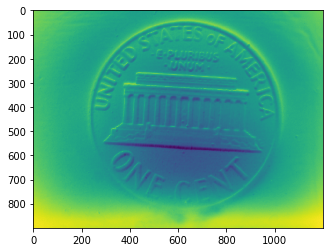

In [12]:
plt.imshow(depth)

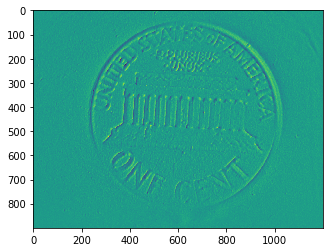

In [13]:
plt.imshow(normals[:,:,0])

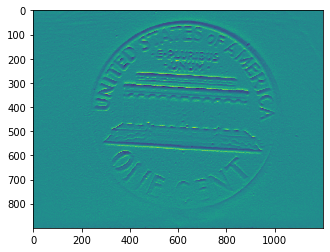

In [14]:
plt.imshow(normals[:,:,1])

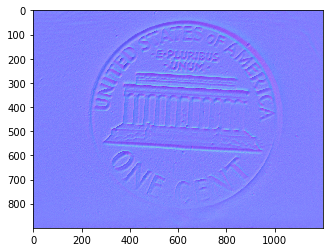

In [15]:
norm_2 = np.stack([normals[:,:,0],normals[:,:,1],np.ones_like(img)])
norm_2 = np.moveaxis(norm_2,0,2)
norm_2 /= np.linalg.norm(norm_2,axis=2,keepdims=True)
plt.imshow(0.5*(norm_2+1))

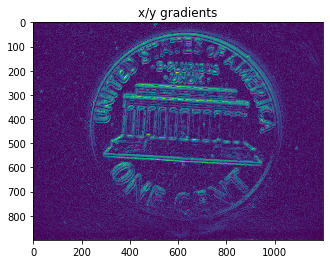

In [16]:
plt.title("x/y gradients")
plt.imshow(np.sqrt(norm_2[:,:,1]**2 + norm_2[:,:,0]**2))

## linear shape from shading number
this time following [Pentland, Alex. "Shape information from shading: a theory about human perception." Spatial vision 4.2-3 (1989): 165-182.](http://www.cnbc.cmu.edu/~tai/readings/shading/pentland.pdf)

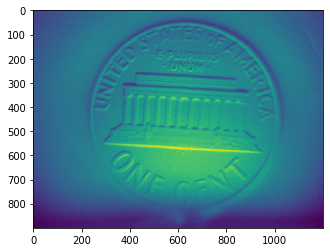

In [17]:
Img = np.fft.fft2(img)
xi,yi = np.meshgrid(np.arange(0,img.shape[1]),np.arange(0,img.shape[0]))
wx = (2*np.pi * xi)/img.shape[1]
wy = (2*np.pi * yi)/img.shape[0]

R = Img
R /= (-1j * wx * np.cos(tilt) * np.sin(slant)-1j*wy*np.sin(tilt)*np.sin(slant)+1e3)
Z = abs(np.fft.ifft2(R))
plt.imshow(Z)

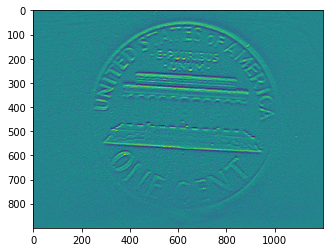

In [18]:
normals_3 = np.gradient(Z)
plt.imshow(normals_3[0])

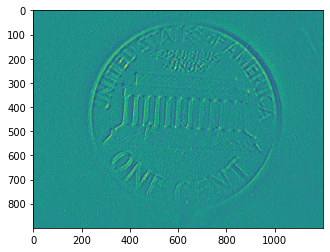

In [19]:
plt.imshow(normals_3[1])

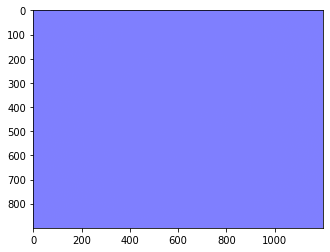

In [20]:
norm_3 = np.stack([normals_3[0],normals_3[1],np.ones_like(img)])
norm_3 = np.moveaxis(norm_3,0,2)
norm_3 /= np.linalg.norm(norm_3,axis=2,keepdims=True)
plt.imshow(0.5*(norm_3+1))

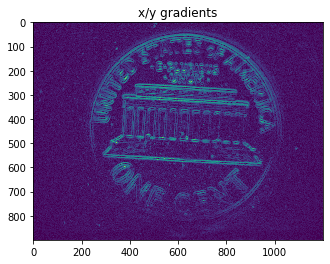

In [21]:
plt.title("x/y gradients")
plt.imshow(np.sqrt(norm_3[:,:,1]**2 + norm_3[:,:,0]**2))

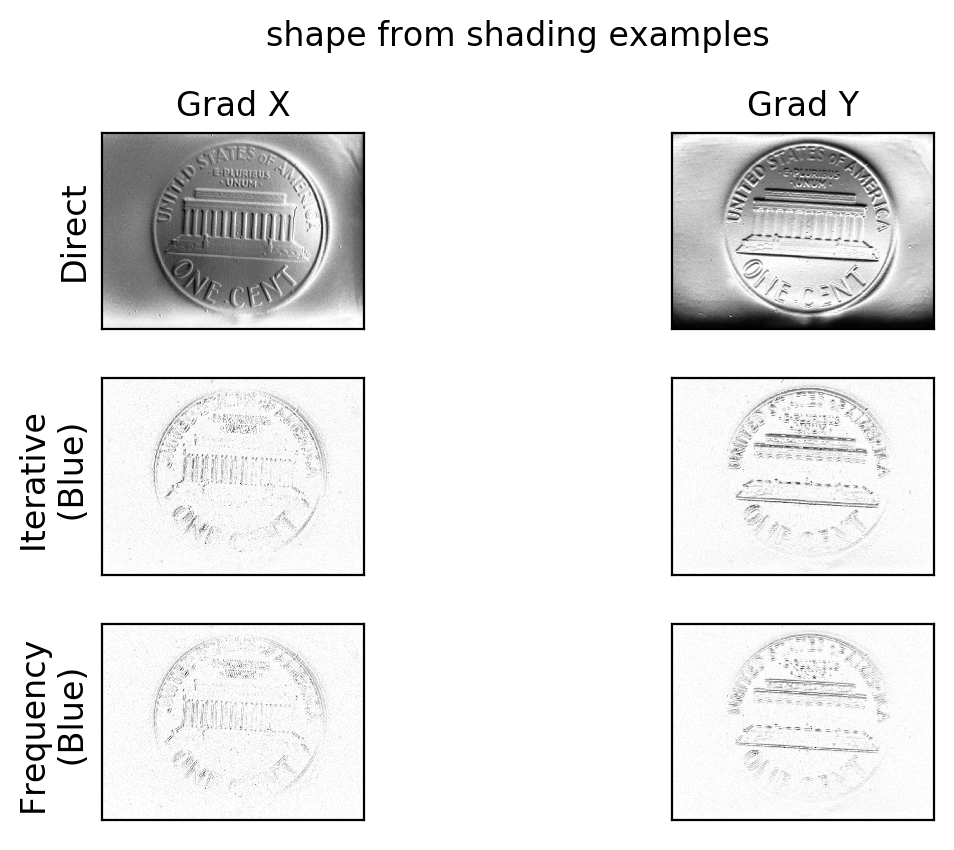

In [22]:
plt.figure(dpi=200)
plt.subplot(3,2,1)
plt.title('Grad X')
plt.imshow(np.sqrt(n_img[:,:,0]**2),cmap='Greys')
plt.gca().set_ylabel('Direct',size='large')

plt.xticks([],[])
plt.yticks([],[])
plt.subplot(3,2,2)
plt.title('Grad Y')

plt.imshow(np.sqrt(n_img[:,:,1]**2),cmap='Greys')
plt.xticks([],[])
plt.yticks([],[])

plt.subplot(3,2,3)
plt.gca().set_ylabel('Iterative \n (Blue)',size='large')

plt.imshow(np.sqrt(norm_2[:,:,0]**2),cmap='Greys')
plt.xticks([],[])
plt.yticks([],[])
plt.subplot(3,2,4)
plt.imshow(np.sqrt(norm_2[:,:,1]**2),cmap='Greys')
plt.xticks([],[])
plt.yticks([],[])

plt.subplot(3,2,5)
plt.gca().set_ylabel('Frequency \n (Blue)',size='large')

plt.imshow(np.sqrt(norm_3[:,:,1]**2),cmap='Greys')
plt.xticks([],[])
plt.yticks([],[])
plt.subplot(3,2,6)
plt.imshow(np.sqrt(norm_3[:,:,0]**2),cmap='Greys')
plt.xticks([],[])
plt.yticks([],[])

plt.suptitle('shape from shading examples',y=1.05)
plt.tight_layout()

plt.subplots_adjust(wspace=0, hspace=0.25)
